## Poker hand classification

Biblioteki

In [2]:
import pandas as pd
import numpy as np

from tensorflow import Tensor
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

from logger import AfterEpochLogger

Funckcja one_hot_encode

In [3]:
def one_hot_encode(x: pd.Series) -> np.array:
    label = x.unique()
    label.sort()
    M = np.eye(x.nunique())
    dictionary = dict(zip(label, M))
    result = []
    for ex in x:
        result.append(dictionary[ex])
    return np.array(result)

Funckcja create_input_layer

In [4]:
def create_input_layer(feature: np.array) -> (Tensor, Tensor):
    input_layer = Input(shape=(len(feature[0]),))
    x = Dense(2, activation='relu', use_bias=True)(input_layer)
    return input_layer, x

Wczytanie danych z pliku

In [ ]:
df = pd.read_csv('poker-hand-testing.data', header=None, sep=',')

Stworzenie sieci

In [5]:
features = df.iloc[:, :-1].copy()
X = []
Y = one_hot_encode(df[len(df.columns) - 1])
for feature_column_number in features:
    X.append(one_hot_encode(features[feature_column_number]))

inputs = []
outputs = []

for i in range(len(X)):
    input, output = create_input_layer(X[i])
    inputs.append(input)
    outputs.append(output)

combined = concatenate(outputs)

h1 = Dense(30, activation='relu', use_bias=True)(combined)
h2 = Dense(20, activation='relu', use_bias=True)(h1)
y = Dense(10, activation='softmax')(h2)

k_fold = KFold(n_splits=5)

loggers = []
scores = []

Uczenie

In [6]:
for train_index, test_index in k_fold.split(X[0]):
    X_train = []
    X_test = []
    for feature_index in range(len(X)):
        X_train.append(X[feature_index][train_index])
        X_test.append(X[feature_index][test_index])
    Y_train, Y_test = Y[train_index], Y[test_index]

    model = Model(inputs=inputs, outputs=y)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam())
    logger = AfterEpochLogger(5)
    model.fit(X_train, Y_train, validation_split=0.2, epochs=10, batch_size=256, callbacks=[logger])

    predicts_train = model.predict(X_train)
    score_train = roc_auc_score(Y_train, predicts_train, average='micro')
    predicts = model.predict(X_test)
    score = roc_auc_score(Y_test, predicts, average='micro')
    print("%s %.2f%%" % ('Train data AUC value for that fold: ', score_train * 100))
    print("%s %.2f%%" % ('Test data AUC value for that fold: ', score * 100))
    scores.append(score * 100)
    loggers.append(logger)

Train on 640000 samples, validate on 160000 samples
Epoch 1/10
640000/640000 [==============================] - 15s 24us/sample - loss: 1.0064 - accuracy: 0.4957 - val_loss: 0.9818 - val_accuracy: 0.4970
Epoch 2/10
640000/640000 [==============================] - 13s 20us/sample - loss: 0.9590 - accuracy: 0.5311 - val_loss: 0.9467 - val_accuracy: 0.5452
Epoch 3/10
640000/640000 [==============================] - 12s 19us/sample - loss: 0.9409 - accuracy: 0.5484 - val_loss: 0.9361 - val_accuracy: 0.5569
Epoch 4/10
640000/640000 [==============================] - 12s 19us/sample - loss: 0.9217 - accuracy: 0.5665 - val_loss: 0.9144 - val_accuracy: 0.5755
Epoch 5/10
637696/640000 [============================>.] - ETA: 0s - loss: 0.9031 - accuracy: 0.5821Epoch: 5
	Train Accuracy:	0.58%	Validation Accuracy	0.59%
	Train Loss	0.90	Validation Loss:	0.90
640000/640000 [==============================] - 14s 22us/sample - loss: 0.9030 - accuracy: 0.5822 - val_loss: 0.8958 - val_accuracy: 0.5898
E

640000/640000 [==============================] - 20s 31us/sample - loss: 0.8193 - accuracy: 0.6282 - val_loss: 0.8164 - val_accuracy: 0.6303
Epoch 2/10
640000/640000 [==============================] - 16s 25us/sample - loss: 0.8187 - accuracy: 0.6292 - val_loss: 0.8164 - val_accuracy: 0.6298
Epoch 3/10
640000/640000 [==============================] - 18s 28us/sample - loss: 0.8181 - accuracy: 0.6289 - val_loss: 0.8193 - val_accuracy: 0.6287
Epoch 4/10
640000/640000 [==============================] - 18s 29us/sample - loss: 0.8177 - accuracy: 0.6291 - val_loss: 0.8204 - val_accuracy: 0.6255
Epoch 5/10
639232/640000 [============================>.] - ETA: 0s - loss: 0.8176 - accuracy: 0.6286Epoch: 5
	Train Accuracy:	0.63%	Validation Accuracy	0.63%
	Train Loss	0.82	Validation Loss:	0.82
640000/640000 [==============================] - 21s 33us/sample - loss: 0.8177 - accuracy: 0.6286 - val_loss: 0.8183 - val_accuracy: 0.6299
Epoch 6/10
640000/640000 [==============================] - 17s 

Wyniki w postaci wykresów

5 fold AUC (2 sigma/95% confidence): 95.70% (+/- 0.34%)


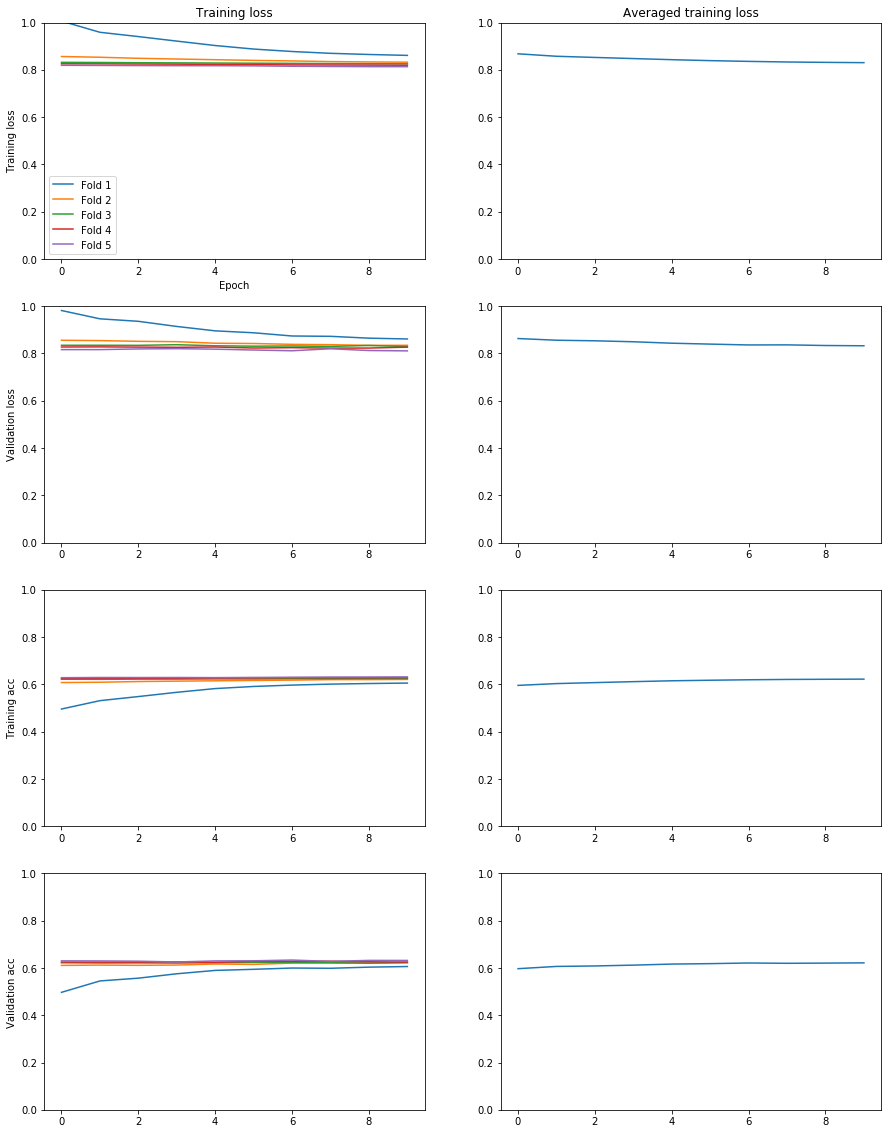

In [7]:
print("5 fold AUC (2 sigma/95%% confidence): %.2f%% (+/- %.2f%%)" % (np.mean(scores), 2*np.std(scores)))
# TODO clean code
plt.figure(figsize=(15, 20))
plt.subplot(421)
plt.ylim([0, 1])
plt.ylabel('Training loss')
plt.xlabel('Epoch')
plt.title('Training loss')
plt.plot(loggers[0].history_loss)
plt.plot(loggers[1].history_loss)
plt.plot(loggers[2].history_loss)
plt.plot(loggers[3].history_loss)
plt.plot(loggers[4].history_loss)
plt.legend(['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5'])
plt.subplot(422)
plt.title('Averaged training loss')
avg_loss = np.sum([loggers[i].history_loss for i in range(5)], axis=0)/5
plt.ylim([0, 1])
plt.plot(avg_loss)

plt.subplot(423)
plt.ylim([0, 1])
plt.ylabel('Validation loss')
plt.plot(loggers[0].val_history_loss)
plt.plot(loggers[1].val_history_loss)
plt.plot(loggers[2].val_history_loss)
plt.plot(loggers[3].val_history_loss)
plt.plot(loggers[4].val_history_loss)
plt.subplot(424)
avg_val_loss = np.sum([loggers[i].val_history_loss for i in range(5)], axis=0)/5
plt.ylim([0,1])
plt.plot(avg_val_loss)

plt.subplot(425)
plt.ylim([0, 1])
plt.ylabel('Training acc')
plt.plot(loggers[0].history_accuracy)
plt.plot(loggers[1].history_accuracy)
plt.plot(loggers[2].history_accuracy)
plt.plot(loggers[3].history_accuracy)
plt.plot(loggers[4].history_accuracy)
plt.subplot(426)
avg_acc = np.sum([loggers[i].history_accuracy for i in range(5)], axis=0)/5
plt.ylim([0, 1])
plt.plot(avg_acc)

plt.subplot(427)
plt.ylim([0, 1])
plt.ylabel('Validation acc')
plt.plot(loggers[0].val_history_accuracy)
plt.plot(loggers[1].val_history_accuracy)
plt.plot(loggers[2].val_history_accuracy)
plt.plot(loggers[3].val_history_accuracy)
plt.plot(loggers[4].val_history_accuracy)
plt.subplot(428)
avg_val_acc = np.sum([loggers[i].val_history_accuracy for i in range(5)], axis=0)/5
plt.ylim([0, 1])
plt.plot(avg_val_acc)

plt.savefig('plot.png')